# Population growth in Denmark

> **Note the following:** 
> 1. This is *not* meant to be an example of an actual **data analysis project**, just an example of how to structure such a project.
> 1. Remember the general advice on structuring and commenting your code from [lecture 5](https://numeconcopenhagen.netlify.com/lectures/Workflow_and_debugging).
> 1. Remember this [guide](https://www.markdownguide.org/basic-syntax/) on markdown and (a bit of) latex.
> 1. Turn on automatic numbering by clicking on the small icon on top of the table of contents in the left sidebar.
> 1. The `dataproject.py` file includes a function which will be used multiple times in this notebook.

Imports and set magics:

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import ipywidgets as widgets
import pydst  
import datetime 
import seaborn as sns

# autoreload modules when code is run
%load_ext autoreload
%autoreload 2


# Read and clean data

In [2]:
Dst = pydst.Dst(lang='en') # Set language to English

First we look at the general list of subjects, that are found in the database of Stastistics Denmark

In [3]:
Dst.get_subjects()

,id,desc,active,hasSubjects
0,02,Population and elections,True,True
1,05,Living conditions,True,True
2,03,Education and knowledge,True,True
3,18,Culture and National Church,True,True
4,04,"Labour, income and wealth",True,True
5,06,Prices and consumption,True,True
6,14,National accounts and government finances,True,True
7,16,Money and credit market,True,True
8,13,External economy,True,True
9,07,Business sector in general,True,True


We decided to invistigate the population growth in different municipalities in Denmark, in order to do so, we find the tables for the general population in each municipality, the number of deaths, people moving in and out of the municipalities, the number of new borns and the number of migrations and immigrations.

### FOLK1A

In this section, we use an API to get the population database on municipality level and clean this data, in order to merge it with the other datasets. 

In [4]:
FOLK1A = Dst.get_variables(table_id = 'FOLK1A') 

In [5]:
FOLK1A [:] ## Looks at what variables that are in the dataset

,id,text,elimination,time,map,values
0,OMRÅDE,region,True,False,denmark_municipality_07,"[{'id': '000', 'text': 'All Denmark'}, {'id': ..."
1,KØN,sex,True,False,NaN,"[{'id': 'TOT', 'text': 'Total'}, {'id': '1', '..."
2,ALDER,age,True,False,NaN,"[{'id': 'IALT', 'text': 'Total'}, {'id': '0', ..."
3,CIVILSTAND,marital status,True,False,NaN,"[{'id': 'TOT', 'text': 'Total'}, {'id': 'U', '..."
4,Tid,time,False,True,NaN,"[{'id': '2008K1', 'text': '2008Q1'}, {'id': '2..."


In [6]:
FOLK1A = Dst.get_data(table_id = 'FOLK1A', variables={'OMRÅDE':['*'], 'TID':['*']}) ## We do not need to get more variables, as there is a total variable. 
FOLK1A.sort_values(['TID'], inplace=True)

In [7]:
I  = FOLK1A.OMRÅDE.str.contains('Region') ## We see if there is any values for regions
FOLK1A.loc[I, :]

,OMRÅDE,TID,KØN,ALDER,CIVILSTAND,INDHOLD
849,Region Syddanmark,2008Q1,Total,Total,Total,1194659
200,Region Sjælland,2008Q1,Total,Total,Total,819427
2993,Region Nordjylland,2008Q1,Total,Total,Total,578839
1282,Region Hovedstaden,2008Q1,Total,Total,Total,1645825
3139,Region Midtjylland,2008Q1,Total,Total,Total,1237041
...,...,...,...,...,...,...
5096,Region Nordjylland,2020Q1,Total,Total,Total,589936
5134,Region Syddanmark,2020Q1,Total,Total,Total,1223105
5114,Region Midtjylland,2020Q1,Total,Total,Total,1326340
5069,Region Sjælland,2020Q1,Total,Total,Total,837359


In [8]:
for val in ['Region', 'All Denmark']:  ## Deletes all "område" with regions
    I = FOLK1A.OMRÅDE.str.contains(val)
    FOLK1A = FOLK1A.loc[I == False] ## and we keep everything else

In [9]:
## 1st quarter for each year is the only observation that we need, therefore we drop all other quaters. This is done in the same way as above

for val in ['2008Q2', '2008Q3', '2008Q4', '2009Q2', '2009Q3', '2009Q4', '2010Q2', '2010Q3', '2010Q4', '2011Q2', '2011Q3', '2011Q4','2012Q2', '2012Q3', '2012Q4', '2013Q2', '2013Q3', '2013Q4', '2014Q2', '2014Q3', '2014Q4', '2015Q2', '2015Q3', '2015Q4', '2016Q2', '2016Q3', '2016Q4', '2017Q2', '2017Q3', '2017Q4', '2018Q2', '2018Q3', '2018Q4', '2019Q2', '2019Q3', '2019Q4' ]: 
    I = FOLK1A.TID.str.contains(val)
    FOLK1A = FOLK1A.loc[I == False] 

In [10]:
drop_these = ['ALDER', 'CIVILSTAND', 'KØN'] ## We drop variables, that we are not going to use anymore
FOLK1A.drop(drop_these, axis=1, inplace=True)
FOLK1A.head(5)

,OMRÅDE,TID,INDHOLD
742,Odsherred,2008Q1,33129
2899,Aalborg,2008Q1,195145
591,Nyborg,2008Q1,31607
602,Kerteminde,2008Q1,23630
2194,Faaborg-Midtfyn,2008Q1,51950


In [11]:
## We need to change the "TID" varibles, from "2008Q1" to "2008", in order for us to merge it with other datasets. 
## We defines a function to map the values 
def set_value(row_number, assigned_value): 
    return assigned_value[row_number] 
  
# Creates a dictionary 
dictionary ={'2008Q1' : 2008, '2009Q1' : 2009, '2010Q1' : 2010, '2011Q1' : 2011, '2012Q1' : 2012, '2013Q1' : 2013, '2014Q1' : 2014, '2015Q1' : 2015, '2016Q1' : 2016, '2017Q1' : 2017, '2018Q1' : 2018, '2019Q1' : 2019, '2020Q1' : 2020} 
  
# Add a new column named 'Nytid', that contains the new 'TID' variable
FOLK1A['Nytid'] = FOLK1A['TID'].apply(set_value, args =(dictionary, ))

In [12]:
drop_these = ['TID'] ## We drop "TID" as we are not going to use it anymore
FOLK1A.drop(drop_these, axis=1, inplace=True)

In [13]:
FOLK1A['Population'] = FOLK1A['INDHOLD'] ## Creates new variables, because we want to change the names
FOLK1A['TID'] = FOLK1A['Nytid']

In [14]:
drop_these = ['Nytid', 'INDHOLD'] ## We drop variables, that we are not going to use anymore, because we created the new variables based on these above
FOLK1A.drop(drop_these, axis=1, inplace=True) 

In [15]:
FOLK1A.head(5)

,OMRÅDE,Population,TID
742,Odsherred,33129,2008
2899,Aalborg,195145,2008
591,Nyborg,31607,2008
602,Kerteminde,23630,2008
2194,Faaborg-Midtfyn,51950,2008


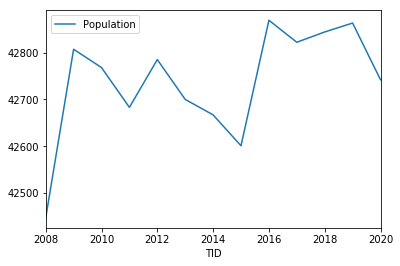

In [16]:
FOLK1A.loc[FOLK1A['OMRÅDE'] == 'Vejen', :].plot(x='TID',y='Population'); ## We plot a graph to see the data

### FLY66

This is a table that tells about the number of people moving in and out of each municipality in Denmark. We are interested in both, so we use the API twice in this section. We start of by looking at people moving into municipalities

#### Tilkommune

In [17]:
FLY66 = Dst.get_variables(table_id = 'FLY66')

In [18]:
FLY66 [:]

,id,text,elimination,time,map,values
0,TILKOMMUNE,in migration,True,False,denmark_municipality_07,"[{'id': '101', 'text': 'Copenhagen'}, {'id': '..."
1,FRAKOMMUNE,out migration,True,False,denmark_municipality_07,"[{'id': '101', 'text': 'Copenhagen'}, {'id': '..."
2,ALDER,age,True,False,NaN,"[{'id': '0', 'text': '0 years'}, {'id': '1', '..."
3,KØN,sex,True,False,NaN,"[{'id': 'M', 'text': 'Men'}, {'id': 'K', 'text..."
4,Tid,time,False,True,NaN,"[{'id': '2006', 'text': '2006'}, {'id': '2007'..."


In [19]:
TILKOMMUNEFLY66 = Dst.get_data(table_id = 'FLY66', variables={'TILKOMMUNE':['*'], 'KØN':['*'], 'FRAKOMMUNE':['*'], 'TID':['*'], 'ALDER':['*']})
TILKOMMUNEFLY66.sort_values(['TID'], inplace=True)

In [20]:
drop_these = ['ALDER', 'FRAKOMMUNE', 'KØN'] ## We drop variables, that we are not going to use anymore
TILKOMMUNEFLY66.drop(drop_these, axis=1, inplace=True) 

In [21]:
TILKOMMUNEFLY66.head(5)

,TILKOMMUNE,TID,INDHOLD
0,Copenhagen,2006,1
93582,Skanderborg,2006,1
93581,Skanderborg,2006,1
93580,Skanderborg,2006,1
93579,Skanderborg,2006,1


The data does not include a total value, therefore we need to create our own total value.

In [22]:
## We create a string in order for us being able to create a total value for each municipality.
TILKOMMUNEFLY66["TILKOMMUNE_OG_TID"] = TILKOMMUNEFLY66["TILKOMMUNE"] + TILKOMMUNEFLY66["TID"].astype(str)

In [23]:
## Here we create a sum, that finds the total number of people moving into a municipality.
TILKOMMUNEFLY66['INDHOLD_csum'] = TILKOMMUNEFLY66.groupby(['TILKOMMUNE_OG_TID'])['INDHOLD'].cumsum()

In [24]:
## We create a new variable, that has the maximimum value for the municipality in the given year written on all variables in that year.
TILKOMMUNEFLY66['Moving in'] = TILKOMMUNEFLY66.groupby(['TILKOMMUNE_OG_TID'])['INDHOLD_csum'].transform(max)

In [25]:
TILKOMMUNEFLY66 = TILKOMMUNEFLY66.drop(TILKOMMUNEFLY66[(TILKOMMUNEFLY66['INDHOLD_csum'] < TILKOMMUNEFLY66['Moving in'])].index) ## Now we delete all but one observation for each municipality and each year, as all observations containts the total value for a given municipality in a given year. This is done in order to reduce the number of observations in the dataset.

In [26]:
TILKOMMUNEFLY66['OMRÅDE']=TILKOMMUNEFLY66['TILKOMMUNE'] ## Rename the variable

In [27]:
drop_these = ['INDHOLD', 'TILKOMMUNE_OG_TID', 'INDHOLD_csum', 'TILKOMMUNE'] ## We drop variables, that we are not going to use anymore
TILKOMMUNEFLY66.drop(drop_these, axis=1, inplace=True)

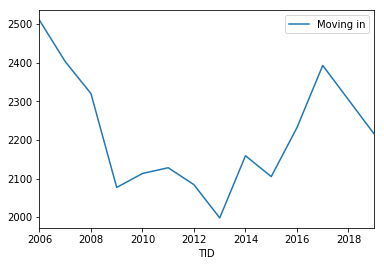

In [28]:
## We make a plot to see if there are any problems in the data
TILKOMMUNEFLY66.loc[TILKOMMUNEFLY66['OMRÅDE'] == 'Aabenraa'].plot(x='TID',y='Moving in'); 

#### Frakommune

Now we repeat the process from above, but in this case, we do not look at people who moved in to the municipalities, but instead people who moved out of the municipalities

In [29]:
FRAKOMMUNEFLY66 = Dst.get_data(table_id = 'FLY66', variables={'TILKOMMUNE':['*'], 'KØN':['*'], 'FRAKOMMUNE':['*'], 'TID':['*'], 'ALDER':['*']}) 
FRAKOMMUNEFLY66.sort_values(['TID'], inplace=True)

In [30]:
drop_these = ['ALDER', 'TILKOMMUNE', 'KØN'] ## Remove variables that we do not use
FRAKOMMUNEFLY66.drop(drop_these, axis=1, inplace=True) 

In [31]:
## We create a string in order for us being able to create a total value for each municipality.
FRAKOMMUNEFLY66["FRAKOMMUNE_OG_TID"] = FRAKOMMUNEFLY66["FRAKOMMUNE"] + FRAKOMMUNEFLY66["TID"].astype(str)

In [32]:
## Here we create a sum, that finds the total number of people moving into a municipality.
FRAKOMMUNEFLY66['INDHOLD_csum'] = FRAKOMMUNEFLY66.groupby(['FRAKOMMUNE_OG_TID'])['INDHOLD'].cumsum()

In [33]:
## We create a new variable, that has the maximimum value for the municipality in the given year written on all variables in that year.
FRAKOMMUNEFLY66['Moving out'] = FRAKOMMUNEFLY66.groupby(['FRAKOMMUNE_OG_TID'])['INDHOLD_csum'].transform(max)

In [34]:
FRAKOMMUNEFLY66 = FRAKOMMUNEFLY66.drop(FRAKOMMUNEFLY66[(FRAKOMMUNEFLY66['INDHOLD_csum'] < FRAKOMMUNEFLY66['Moving out'])].index) ## Now we delete all but one observation for each municipality and each year, as all observations containts the total value for a given municipality in a given year. This is done in order to reduce the number of observations in the dataset.

In [35]:
FRAKOMMUNEFLY66['OMRÅDE']=FRAKOMMUNEFLY66['FRAKOMMUNE']  ## Creates new variables, because we want to change the names

In [36]:
drop_these = ['INDHOLD', 'FRAKOMMUNE_OG_TID', 'INDHOLD_csum', 'FRAKOMMUNE'] ## We drop variables, that we are not going to use anymore
FRAKOMMUNEFLY66.drop(drop_these, axis=1, inplace=True)
FRAKOMMUNEFLY66.head(5)

,TID,Moving out,OMRÅDE
65288,2006,13,Christiansø
51250,2006,1920,Jammerbugt
47780,2006,123,Læsø
47774,2006,1762,Brønderslev
47754,2006,2555,Ringkøbing-Skjern


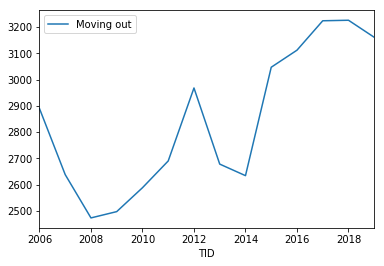

In [37]:
FRAKOMMUNEFLY66.loc[FRAKOMMUNEFLY66['OMRÅDE'] == 'Skanderborg'].plot(x='TID',y='Moving out');
# We plot the data to see if there are any problems 

### VAN1AAR

This table shows the amount of people migrating into Denmark and which municipality they migrate into.

In [38]:
VAN1AAR = Dst.get_variables(table_id = 'VAN1AAR')

In [39]:
VAN1AAR [:] ## Checks variables in the VAN1AAR table

,id,text,elimination,time,map,values
0,OMRÅDE,region,True,False,denmark_municipality_07,"[{'id': '000', 'text': 'All Denmark'}, {'id': ..."
1,KØN,sex,True,False,NaN,"[{'id': '1', 'text': 'Men'}, {'id': '2', 'text..."
2,ALDER,age,True,False,NaN,"[{'id': '0', 'text': '0 years'}, {'id': '1', '..."
3,INDVLAND,country of last residence,True,False,Verden_dk2,"[{'id': '5901', 'text': 'Faroe Islands'}, {'id..."
4,STATSB,citizenship,True,False,Verden_dk2,"[{'id': '5100', 'text': 'Denmark'}, {'id': '51..."
5,Tid,time,False,True,NaN,"[{'id': '2007', 'text': '2007'}, {'id': '2008'..."


In [40]:
VAN1AAR= Dst.get_data(table_id = 'VAN1AAR', variables={'OMRÅDE':['*'], 'TID':['*'],'ALDER':['*'], 'INDVLAND':['*'], 'KØN':['*'], 'STATSB':['*']}) ## Gets all variables from the table 
VAN1AAR.sort_values(['TID'], inplace=True)
VAN1AAR.head(10)

,OMRÅDE,TID,ALDER,INDVLAND,KØN,STATSB,INDHOLD
522437,All Denmark,2007,48 years,France,Women,Ireland,1
575557,Region Syddanmark,2007,35 years,United Kingdom,Women,Germany,1
691012,Hillerød,2007,60 years,Thailand,Men,Denmark,1
373602,Vordingborg,2007,26 years,Ukraine,Men,Ukraine,3
691024,Hillerød,2007,62 years,Switzerland,Men,Denmark,1
373595,Vordingborg,2007,26 years,Lithuania,Men,Latvia,1
181535,Copenhagen,2007,47 years,France,Women,France,2
373586,Vordingborg,2007,26 years,Iraq,Men,Iraq,1
691029,Hillerød,2007,63 years,Sweden,Men,Denmark,1
475653,Gentofte,2007,11 years,Brazil,Women,Brazil,1


In [41]:
## The table includes regions, which we do not care about, therefore we remove all regions and the total for Denmark variable

for val in ['Region', 'All Denmark']:  
    I = VAN1AAR.OMRÅDE.str.contains(val)
    VAN1AAR = VAN1AAR.loc[I == False]

VAN1AAR.head(10)

,OMRÅDE,TID,ALDER,INDVLAND,KØN,STATSB,INDHOLD
691012,Hillerød,2007,60 years,Thailand,Men,Denmark,1
373602,Vordingborg,2007,26 years,Ukraine,Men,Ukraine,3
691024,Hillerød,2007,62 years,Switzerland,Men,Denmark,1
373595,Vordingborg,2007,26 years,Lithuania,Men,Latvia,1
181535,Copenhagen,2007,47 years,France,Women,France,2
373586,Vordingborg,2007,26 years,Iraq,Men,Iraq,1
691029,Hillerød,2007,63 years,Sweden,Men,Denmark,1
475653,Gentofte,2007,11 years,Brazil,Women,Brazil,1
373580,Gentofte,2007,34 years,Singapore,Men,Singapore,1
691036,Hillerød,2007,64 years,Vietnam,Men,Denmark,1


In [42]:
drop_these = ['ALDER', 'INDVLAND', 'KØN', 'STATSB'] ## Drops all unused variables
VAN1AAR.drop(drop_these, axis=1, inplace=True) 
VAN1AAR.head(5)

,OMRÅDE,TID,INDHOLD
691012,Hillerød,2007,1
373602,Vordingborg,2007,3
691024,Hillerød,2007,1
373595,Vordingborg,2007,1
181535,Copenhagen,2007,2


In [43]:
## We create a string in order for us being able to create a total value for each municipality.
VAN1AAR["OMRÅDE_OG_TID"] = VAN1AAR["OMRÅDE"] + VAN1AAR["TID"].astype(str)

In [44]:
## Here we create a sum, that finds the total number of people moving into a municipality.
VAN1AAR['INDHOLD_csum'] = VAN1AAR.groupby(['OMRÅDE_OG_TID'])['INDHOLD'].cumsum()

In [45]:
## We create a new variable, that has the maximimum value for the municipality in the given year written on all variables in that year.
VAN1AAR['Immigration'] = VAN1AAR.groupby(['OMRÅDE_OG_TID'])['INDHOLD_csum'].transform(max)

In [46]:
VAN1AAR = VAN1AAR.drop(VAN1AAR[(VAN1AAR['INDHOLD_csum'] < VAN1AAR['Immigration'])].index) ## Now we delete all but one observation for each municipality and each year, as all observations containts the total value for a given municipality in a given year. This is done in order to reduce the number of observations in the dataset.

In [47]:
drop_these = ['INDHOLD', 'OMRÅDE_OG_TID', 'INDHOLD_csum'] ## Drop all unused variables
VAN1AAR.drop(drop_these, axis=1, inplace=True)
VAN1AAR.head(5)

,OMRÅDE,TID,Immigration
728418,Christiansø,2007,1
435968,Lolland,2007,263
666133,Odsherred,2007,206
172067,Faxe,2007,212
399970,Middelfart,2007,286


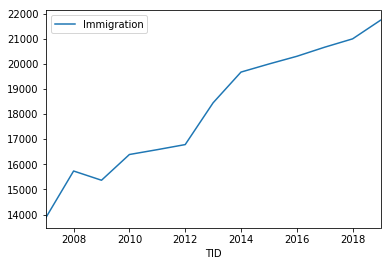

In [48]:
VAN1AAR.loc[VAN1AAR['OMRÅDE'] == 'Copenhagen', :].plot(x='TID',y='Immigration'); 
#Plot the data to see if there are any problems

### FODIE

This table shows all newborns in different municipalities in Denmark

In [49]:
FODIE = Dst.get_variables(table_id = 'FODIE')

In [50]:
FODIE [:]

,id,text,elimination,time,map,values
0,OMRÅDE,region,True,False,denmark_municipality_07,"[{'id': '000', 'text': 'All Denmark'}, {'id': ..."
1,MOHERK,mothers ancestry,True,False,NaN,"[{'id': '5', 'text': 'Persons of Danish origin..."
2,MOOPRIND,mothers country of origin,True,False,Verden_dk2,"[{'id': '5100', 'text': 'Denmark'}, {'id': '51..."
3,MOSTAT,mothers citizenship,True,False,Verden_dk2,"[{'id': '5100', 'text': 'Denmark'}, {'id': '51..."
4,MODERSALDER,age of mother,True,False,NaN,"[{'id': '10', 'text': '10 years'}, {'id': '11'..."
5,BARNKON,sex of child,True,False,NaN,"[{'id': 'D', 'text': 'Boys'}, {'id': 'P', 'tex..."
6,Tid,time,False,True,NaN,"[{'id': '2007', 'text': '2007'}, {'id': '2008'..."


In [51]:
FODIE= Dst.get_data(table_id = 'FODIE', variables={'OMRÅDE':['*'], 'MOHERK':['*'], 'Tid':['*'], 'MODERSALDER':['*'], 'MOOPRIND':['*'], 'MOSTAT':['*'], 'BARNKON':['*']}) #We keep all variables
FODIE.sort_values(['TID'], inplace=True)


In [52]:
for val in ['Region', 'All Denmark']:  ## Drops 'All Denmark' and region observations
    I = FODIE.OMRÅDE.str.contains(val)
    FODIE = FODIE.loc[I == False] 

In [53]:
drop_these = ['MODERSALDER', 'MOHERK', 'MOOPRIND', 'MOSTAT', 'BARNKON'] ## Drops unused variables
FODIE.drop(drop_these, axis=1, inplace=True) 

In [54]:
## We create a string in order for us to create a total value for each municipality.
FODIE["OMRÅDE_OG_TID"] = FODIE["OMRÅDE"] + FODIE["TID"].astype(str)

In [55]:
## Here we create a sum, that finds the total number of birts in a municipality.
FODIE['INDHOLD_csum'] = FODIE.groupby(['OMRÅDE_OG_TID'])['INDHOLD'].cumsum()

In [56]:
## We create a new variable, that has the maximimum value for the municipality in the given year written on all variables in that year.
FODIE['Newborns'] = FODIE.groupby(['OMRÅDE_OG_TID'])['INDHOLD_csum'].transform(max)

In [57]:
FODIE = FODIE.drop(FODIE[(FODIE['INDHOLD_csum'] < FODIE['Newborns'])].index) ## Now we delete all but one observation for each municipality and each year, as all observations containts the total value for a given municipality in a given year. This is done in order to reduce the number of observations in the dataset.

In [58]:
drop_these = ['INDHOLD', 'OMRÅDE_OG_TID', 'INDHOLD_csum'] ## Drop all unused variables
FODIE.drop(drop_these, axis=1, inplace=True) 
FODIE.head(5)

,OMRÅDE,TID,Newborns
41122,Ærø,2007,36
41128,Nyborg,2007,336
10872,Halsnæs,2007,326
36242,Gribskov,2007,394
10638,Ishøj,2007,262


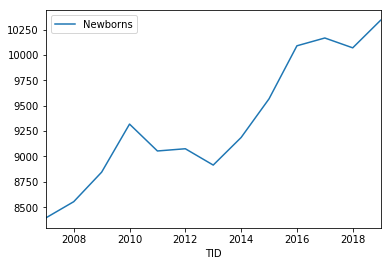

In [59]:
FODIE.loc[FODIE['OMRÅDE'] == 'Copenhagen', :].plot(x='TID',y='Newborns'); 
#Plot the data to see if there are any problems

### FOD207

This table includes the number of deaths in each municipality in Denmark

In [60]:
FOD207 = Dst.get_variables(table_id = 'FOD207')

In [61]:
FOD207 [:] ## Checks the variables in the dataset

,id,text,elimination,time,map,values
0,OMRÅDE,region,True,False,denmark_municipality_07,"[{'id': '000', 'text': 'All Denmark'}, {'id': ..."
1,ALDER,age,True,False,NaN,"[{'id': 'TOT', 'text': 'Age, total'}, {'id': '..."
2,KØN,sex,True,False,NaN,"[{'id': 'M', 'text': 'Men'}, {'id': 'K', 'text..."
3,Tid,time,False,True,NaN,"[{'id': '2006', 'text': '2006'}, {'id': '2007'..."


In [62]:
FOD207= Dst.get_data(table_id = 'FOD207', variables={'OMRÅDE':['*'], 'TID':['*'],'KØN':['*'], 'ALDER':['*']})
FOD207.sort_values(['TID'], inplace=True) ## We want to use all available data
FOD207.head(10000)

,OMRÅDE,TID,KØN,ALDER,INDHOLD
0,Glostrup,2006,Women,52 years,2
28363,Bornholm,2006,Women,25 years,0
28364,Bornholm,2006,Men,26 years,0
28365,Bornholm,2006,Women,26 years,0
28366,Bornholm,2006,Men,27 years,0
...,...,...,...,...,...
26345,Rødovre,2006,Women,36 years,0
26346,Rødovre,2006,Men,37 years,0
26347,Rødovre,2006,Women,37 years,0
26348,Rødovre,2006,Men,38 years,0


In [63]:
for val in ['Region', 'All Denmark']: ## Removing Regions and All Denmark variables
    I = FOD207.OMRÅDE.str.contains(val)
    FOD207 = FOD207.loc[I == False] # keep everything else

In [64]:
FOD207.head(5)

,OMRÅDE,TID,KØN,ALDER,INDHOLD
0,Glostrup,2006,Women,52 years,2
28363,Bornholm,2006,Women,25 years,0
28364,Bornholm,2006,Men,26 years,0
28365,Bornholm,2006,Women,26 years,0
28366,Bornholm,2006,Men,27 years,0


In [65]:
drop_these = ['KØN', 'ALDER'] # We drop the variables we donot need
FOD207.drop(drop_these, axis=1, inplace=True)
FOD207.head(5)

,OMRÅDE,TID,INDHOLD
0,Glostrup,2006,2
28363,Bornholm,2006,0
28364,Bornholm,2006,0
28365,Bornholm,2006,0
28366,Bornholm,2006,0


In [66]:
## We create a string in order for us being able to create a total value for each municipality.
FOD207["OMRÅDE_OG_TID"] = FOD207["OMRÅDE"] + FOD207["TID"].astype(str)

In [67]:
## Here we create a sum, that finds the total number of deaths in a municipality.
FOD207['INDHOLD_csum'] = FOD207.groupby(['OMRÅDE_OG_TID'])['INDHOLD'].cumsum()

In [68]:
## We create a new variable, that has the maximimum value for the municipality in the given year written on all variables in that year.
FOD207['count_max'] = FOD207.groupby(['OMRÅDE_OG_TID'])['INDHOLD_csum'].transform(max)
FOD207.head(5)

,OMRÅDE,TID,INDHOLD,OMRÅDE_OG_TID,INDHOLD_csum,count_max
0,Glostrup,2006,2,Glostrup2006,2,500
28363,Bornholm,2006,0,Bornholm2006,0,1104
28364,Bornholm,2006,0,Bornholm2006,0,1104
28365,Bornholm,2006,0,Bornholm2006,0,1104
28366,Bornholm,2006,0,Bornholm2006,0,1104


In [69]:
FOD207['Deaths'] = FOD207['count_max']/2 ## Since the maximum value is twice as high, as the value in Statistikbanken, we divide such that the values match the values of Statistikbanken

In [70]:
FOD207 = FOD207.drop(FOD207[(FOD207['INDHOLD_csum'] < FOD207['count_max'])].index) ## Now we delete all but one observation for each municipality and each year, as all observations containts the total value for a given municipality in a given year. This is done in order to reduce the number of observations in the dataset.

In [71]:
FOD207 = FOD207.drop(FOD207[(FOD207['INDHOLD'] == 0 )].index) ## Drop all values that contains a zero value in 'INDHOLD'

In [72]:
drop_these = ['INDHOLD', 'OMRÅDE_OG_TID', 'INDHOLD_csum', 'count_max'] ## Drop all unused variables
FOD207.drop(drop_these, axis=1, inplace=True) 
FOD207.head(5)

,OMRÅDE,TID,Deaths
28161,Vordingborg,2006,620.0
13974,Halsnæs,2006,367.0
13952,Køge,2006,475.0
27126,Aalborg,2006,1845.0
27749,Horsens,2006,750.0


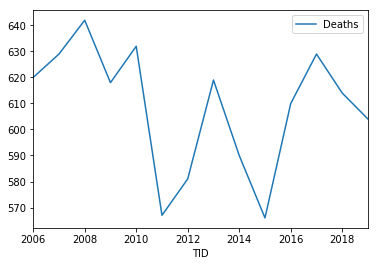

In [73]:
FOD207.loc[FOD207['OMRÅDE'] == 'Vordingborg', :].plot(x='TID',y='Deaths'); 
# Plot the data to see if there are any problems

### VAN2AAR

This table contains migration out of Denmark on municipality level

In [74]:
VAN2AAR = Dst.get_variables(table_id = 'VAN2AAR')

In [75]:
VAN2AAR [:] ## Checks what variables that are in the table

,id,text,elimination,time,map,values
0,OMRÅDE,region,True,False,denmark_municipality_07,"[{'id': '000', 'text': 'All Denmark'}, {'id': ..."
1,KØN,sex,True,False,NaN,"[{'id': '1', 'text': 'Men'}, {'id': '2', 'text..."
2,ALDER,age,True,False,NaN,"[{'id': '0', 'text': '0 years'}, {'id': '1', '..."
3,UDVLAND,country of destination,True,False,Verden_dk2,"[{'id': '5901', 'text': 'Faroe Islands'}, {'id..."
4,STATSB,citizenship,True,False,Verden_dk2,"[{'id': '5100', 'text': 'Denmark'}, {'id': '51..."
5,Tid,time,False,True,NaN,"[{'id': '2007', 'text': '2007'}, {'id': '2008'..."


In [76]:
VAN2AAR= Dst.get_data(table_id = 'VAN2AAR', variables={'OMRÅDE':['*'], 'TID':['*'], 'ALDER':['*'], 'UDVLAND':['*'], 'STATSB':['*'], 'KØN':['*']}) ## Gets all data that are in the table
VAN2AAR.sort_values(['TID'], inplace=True)
VAN2AAR.head(1000000)

,OMRÅDE,TID,ALDER,UDVLAND,STATSB,KØN,INDHOLD
607409,Region Nordjylland,2007,8 years,Not stated,Denmark,Men,1
198671,Ikast-Brande,2007,61 years,Germany,Denmark,Men,1
52886,Region Hovedstaden,2007,57 years,France,Switzerland,Women,1
405055,Region Hovedstaden,2007,46 years,Latvia,Latvia,Men,1
52889,Region Hovedstaden,2007,57 years,Netherlands,Denmark,Women,1
...,...,...,...,...,...,...,...
918428,Varde,2019,25 years,Germany,Germany,Women,1
918427,Varde,2019,25 years,United Kingdom,United Kingdom,Women,1
918426,Varde,2019,25 years,Spain,Denmark,Women,1
918425,Varde,2019,24 years,Ukraine,Ukraine,Women,2


In [77]:
for val in ['Region', 'All Denmark']: ## Removing Regions and All Denmark variables
    I = VAN2AAR.OMRÅDE.str.contains(val)
    VAN2AAR = VAN2AAR.loc[I == False] 

In [78]:
drop_these = ['KØN', 'ALDER', 'UDVLAND', 'STATSB'] ## Drops unused variables
VAN2AAR.drop(drop_these, axis=1, inplace=True)
VAN2AAR.head(5)

,OMRÅDE,TID,INDHOLD
198671,Ikast-Brande,2007,1
480381,Copenhagen,2007,1
301974,Viborg,2007,1
301983,Viborg,2007,1
435878,Randers,2007,1


In [79]:
## We create a string in order for us being able to create a total value for each municipality.
VAN2AAR["OMRÅDE_OG_TID"] = VAN2AAR["OMRÅDE"] + VAN2AAR["TID"].astype(str)

In [80]:
## Here we create a sum, that finds the total number of people migrating in to a municipality.
VAN2AAR['INDHOLD_csum'] = VAN2AAR.groupby(['OMRÅDE_OG_TID'])['INDHOLD'].cumsum()

In [81]:
## We create a new variable, that has the maximimum value for the municipality in the given year written on all variables in that year.
VAN2AAR['Migration'] = VAN2AAR.groupby(['OMRÅDE_OG_TID'])['INDHOLD_csum'].transform(max)

In [82]:
VAN2AAR = VAN2AAR.drop(VAN2AAR[(VAN2AAR['INDHOLD_csum'] < VAN2AAR['Migration'])].index) ## Now we delete all but one observation for each municipality and each year, as all observations containts the total value for a given municipality in a given year. This is done in order to reduce the number of observations in the dataset.

In [83]:
drop_these = ['INDHOLD', 'OMRÅDE_OG_TID', 'INDHOLD_csum'] ## Drop all unused variables
VAN2AAR.drop(drop_these, axis=1, inplace=True) 
VAN2AAR.head(5)

,OMRÅDE,TID,Migration
441742,Samsø,2007,43
345341,Stevns,2007,79
203701,Morsø,2007,63
117650,Allerød,2007,180
607169,Fanø,2007,15


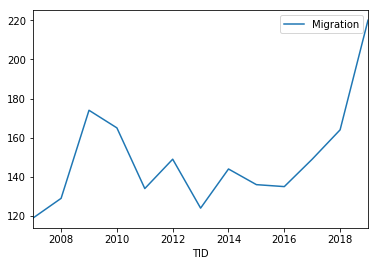

In [84]:
VAN2AAR.loc[VAN2AAR['OMRÅDE'] == 'Jammerbugt', :].plot(x='TID',y='Migration'); 
# Plot the data to see if there are any problems

## Merge data

In this section, we merge all the tables above together based on 'OMRÅDE' and 'TID', this is done in six steps, by merging two tables at the time. We further keep track of, if we lose any observations.

In [85]:
merged = pd.merge(VAN1AAR, VAN2AAR, how='inner',on=['OMRÅDE','TID'])

print(f'Number of municipalities = {len(merged.OMRÅDE.unique())}') #Check the number of municipalities
print(f'Number of years          = {len(merged.TID.unique())}') #Check the number of years

Number of municipalities = 99
Number of years          = 13


In [86]:
merged2 = pd.merge(merged, FODIE, how='inner',on=['OMRÅDE','TID'])

print(f'Number of municipalities = {len(merged2.OMRÅDE.unique())}') #Check the number of municipalities
print(f'Number of years          = {len(merged2.TID.unique())}') #Check the number of years

Number of municipalities = 98
Number of years          = 13


So here, we have lost a municipality, but now the number matches the 98 muniplalities that there are in Denmark

In [87]:
merged3 = pd.merge(merged2, FRAKOMMUNEFLY66, how='inner',on=['OMRÅDE','TID'])

print(f'Number of municipalities = {len(merged3.OMRÅDE.unique())}') #Check the number of municipalities
print(f'Number of years          = {len(merged3.TID.unique())}') #Check the number of years

Number of municipalities = 98
Number of years          = 13


In [88]:
merged4 = pd.merge(merged3, TILKOMMUNEFLY66, how='inner',on=['OMRÅDE','TID'])

print(f'Number of municipalities = {len(merged4.OMRÅDE.unique())}') #Check the number of municipalities
print(f'Number of years          = {len(merged4.TID.unique())}') #Check the number of years

Number of municipalities = 98
Number of years          = 13


In [89]:
merged5 = pd.merge(merged4, FOD207, how='inner',on=['OMRÅDE','TID'])

print(f'Number of municipalities = {len(merged5.OMRÅDE.unique())}') #Check the number of municipalities
print(f'Number of years          = {len(merged5.TID.unique())}') #Check the number of years

Number of municipalities = 98
Number of years          = 13


In [90]:
merged6 = pd.merge(merged5, FOLK1A, how='inner',on=['OMRÅDE','TID'])

print(f'Number of municipalities = {len(merged6.OMRÅDE.unique())}') #Check the number of municipalities
print(f'Number of years          = {len(merged6.TID.unique())}') #Check the number of years

Number of municipalities = 98
Number of years          = 12


Now we have lost a year, meaning that we have data for 2008 and to 2019, which can be seen below.

In [91]:
merged6.TID.unique() # Check the years appearing in the dataset

array([2008, 2009, 2010, 2011, 2012, 2013, 2014, 2015, 2016, 2017, 2018,
       2019])

In [92]:
merged6.head(5)

,OMRÅDE,TID,Immigration,Migration,Newborns,Moving out,Moving in,Deaths,Population
0,Læsø,2008,8,4,15,99,99,29.0,2003
1,Morsø,2008,229,79,232,853,767,292.0,22091
2,Norddjurs,2008,260,129,335,1850,1659,472.0,38581
3,Skive,2008,392,243,521,1897,1649,473.0,48356
4,Dragør,2008,161,85,123,591,683,139.0,13261


Creating a new dataset, in order to calculate the total for all of Denmark, this is done by using the same steps as for all other total variables created. 

In [93]:
Total = merged6.copy(deep=True) ## Creates a deep copy, such that the merged6 dataframe is not affected by changes to the Total dataframe

In [94]:
Total['Csum_immigration'] = Total.groupby(['TID'])['Immigration'].cumsum()
Total['T_immigration'] = Total.groupby(['TID'])['Csum_immigration'].transform(max)
Total['Csum_Migration'] = Total.groupby(['TID'])['Migration'].cumsum()
Total['T_Migration'] = Total.groupby(['TID'])['Csum_Migration'].transform(max)
Total['Csum_Newborns'] = Total.groupby(['TID'])['Newborns'].cumsum()
Total['T_Newborns'] = Total.groupby(['TID'])['Csum_Newborns'].transform(max)
Total['Csum_Deaths'] = Total.groupby(['TID'])['Deaths'].cumsum()
Total['T_Deaths'] = Total.groupby(['TID'])['Csum_Deaths'].transform(max)
Total['Csum_Moving in'] = Total.groupby(['TID'])['Moving in'].cumsum()
Total['T_Moving in'] = Total.groupby(['TID'])['Csum_Moving in'].transform(max)
Total['Csum_Moving out'] = Total.groupby(['TID'])['Moving out'].cumsum()
Total['T_Moving out'] = Total.groupby(['TID'])['Csum_Moving out'].transform(max)
Total['Csum_Population'] = Total.groupby(['TID'])['Population'].cumsum()
Total['T_Population'] = Total.groupby(['TID'])['Csum_Population'].transform(max)

In [95]:
Total = Total.drop(Total[(Total['Csum_Population'] < Total['T_Population'])].index) ## Now we delete all but one observation for each municipality and each year, as all observations containts the total value for a given municipality in a given year. This is done in order to reduce the number of observations in the dataset.

drop_these = ['Csum_Population', 'Csum_Moving out', 'Csum_Moving in', 'Csum_Deaths', 'Csum_Newborns', 'Csum_Migration', 'Csum_immigration', 'Immigration', 'Migration', 'Newborns', 'Moving out', 'Moving in', 'Deaths', 'Population', 'OMRÅDE'] ## Drop all unused variables
Total.drop(drop_these, axis=1, inplace=True) 

In [96]:
old_names = ['T_Population', 'T_Moving out', 'T_Moving in', 'T_Newborns', 'T_Deaths', 'T_Migration', 'T_immigration'] 
new_names = ['Population', 'Moving out', 'Moving in', 'Newborns', 'Deaths', 'Migration', 'Immigration']
Total.rename(columns=dict(zip(old_names, new_names)), inplace=True) #Rename the variables in the dataset, such that we drop T_ in the name

In [97]:
Total.head(5)

,TID,Immigration,Migration,Newborns,Deaths,Moving in,Moving out,Population
97,2008,73762,48171,65037,54590.0,274227,274227,5475695
195,2009,68443,51988,62816,54872.0,268043,268046,5511355
293,2010,69200,52097,63410,54367.0,273956,273949,5534637
391,2011,70122,55782,58997,52516.0,279292,279300,5560534
489,2012,72512,54907,57916,52325.0,287268,287257,5580413


# Analysis

We start of by creating a varible that calculates the population growth in each municipality in the given year, as this can tell something about the generel growth in the municipalities

In [98]:
merged6['Population Growth'] = merged6['Immigration'] - merged6['Migration'] + merged6['Newborns'] - merged6['Deaths'] + merged6['Moving in'] - merged6['Moving out']

In [108]:
# Defing a function that creates the figure for the municipality, such that we can choose the municipality to investigate
def plot_func(Municipality):
    for val in [Municipality]: #Choosing values for the choosen municipality
        I = merged6.OMRÅDE.str.contains(val)
        dataset = merged6.loc[I == True]
    
    fig = plt.figure(figsize=(12,12)) # Defining figure size

# Defining the top left plot 
    ax_left_top = fig.add_subplot(221)  
    ax_left_top.plot(dataset['TID'],dataset['Newborns']) 
    ax_left_top.plot(dataset['TID'],dataset['Deaths'])
    ax_left_top.legend()
    ax_left_top.set_title('Plot of newborns and deaths')
    ax_left_top.set_xlabel('Year')
    ax_left_top.set_ylabel('People')
    ax_left_top.grid(True)

# Defining the bottom left plot
    ax_left_bottom = fig.add_subplot(223)  
    ax_left_bottom.plot(dataset['TID'],dataset['Moving in']) 
    ax_left_bottom.plot(dataset['TID'],dataset['Moving out'])
    ax_left_bottom.legend() 
    ax_left_bottom.set_title('Plot of Moving in and moving out')
    ax_left_bottom.set_xlabel('Year')
    ax_left_bottom.set_ylabel('People')
    ax_left_bottom.grid(True)

# Defining the top right plot
    ax_right_top = fig.add_subplot(222)
    ax_right_top.plot(dataset['TID'],dataset['Immigration'])
    ax_right_top.plot(dataset['TID'],dataset['Migration'])
    ax_right_top.set_title('Plot of immigration and migration')
    ax_right_top.set_xlabel('Year')
    ax_right_top.legend()
    ax_right_top.grid(True)

# Defining the bottom right plot
    ax_right_bottom = fig.add_subplot(224)
    ax_right_bottom.plot(dataset['TID'],dataset['Population'])
    ax_right_bottom.legend() 
    ax_right_bottom.set_title('Plot of population')
    ax_right_bottom.set_xlabel('Year')
    ax_right_bottom.grid(True)

Now we turn to look at a specific municipality, and how the population growth have been there, we have chosen the municipality of Vejen in southern Jutland

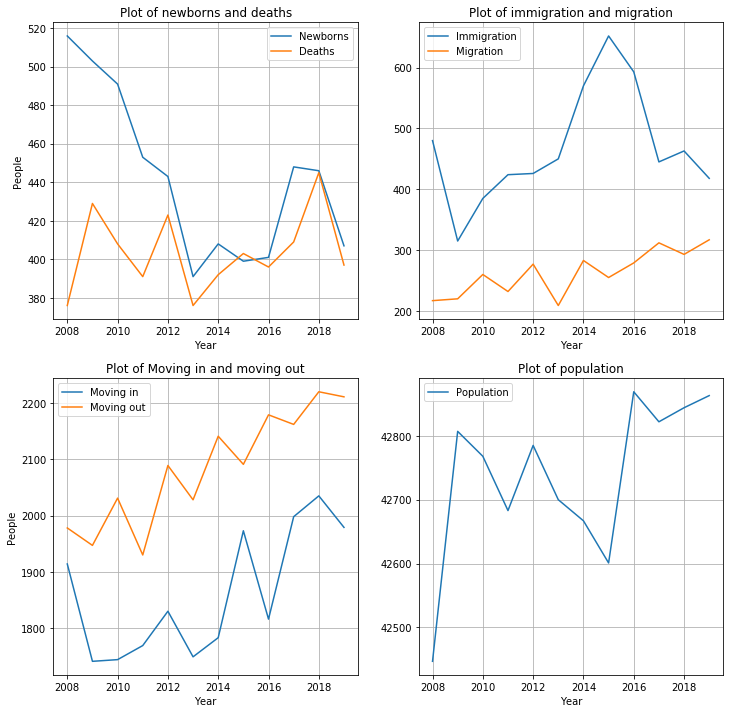

In [116]:
plot_func('Vejen') # Choosing which municipality we want to investigate

It can be seen that the immigration increased in 2015 following "Flytningekrisen", and thereafter decreased to the previous level. The number of newborns experienced a decreas from 2008 to 2016, while the amount of people moving out has increased. Though Vejen has experienced a decreasing amount of people staying in the municipality, they still experience an increase in the population, though mainly due to "Flytningekrisen" in 2015.

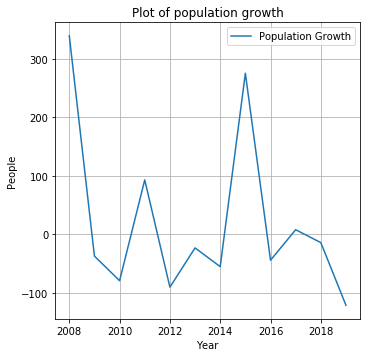

In [357]:
# Creating the figure
fig = plt.figure(figsize=(12,12)) # Defining figure size

# Defining the top left plot
ax_left_top = fig.add_subplot(221)  
ax_left_top.plot(Vejen['TID'],Vejen['Population Growth']) 
ax_left_top.legend()
ax_left_top.set_title('Plot of population growth')
ax_left_top.set_xlabel('Year')
ax_left_top.set_ylabel('People')
ax_left_top.grid(True)

Above we have a plot of the population growth, where the effect of "Flytningekrisen" can be seen. Further it can be seen that there are more years with a negative population growth than with positive population growth.

We now look at the municipality of Læsø, which is a island off the coast of Jutland. 

In [363]:
for val in ['Læsø']: 
    I = merged6.OMRÅDE.str.contains(val)
    Læsø = merged6.loc[I == True] # Creating a dataset which only contain values for Læsø

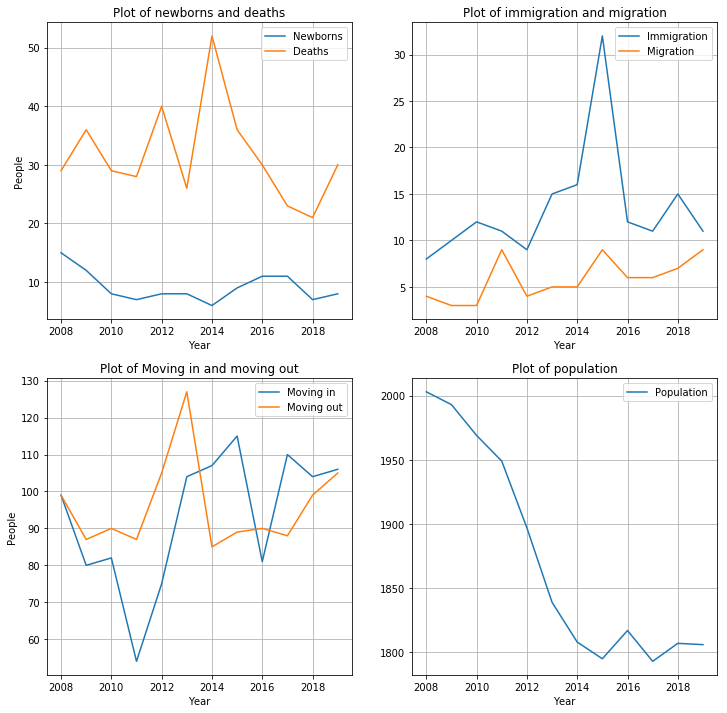

In [364]:
plot_func(Læsø)

In Læsø they have experienced a negative population growth in the periode. Around 10 people are born each year, while 30-50 people die each year. Combining that with the fact that more people are moving out of the municipality compared to moving in, in the period 2008 to 2013, gives a negative population growth. This can be seen in the plot of the total population which has decrease with around 200 persons from 2008 to 2014, while staying relative constant after 2014. This may be the case that more people has moved in compared to moving out, thus they make up for the number of people dying in Læsø. It can be seen that there also is an effect of "Flytningekrisen" on immigration on Læsø.

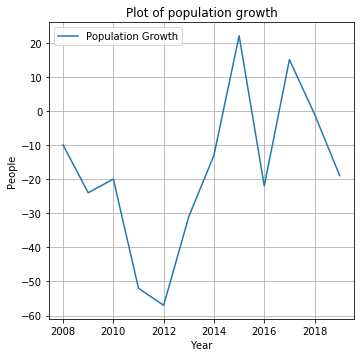

In [360]:
# Creating the figure
fig = plt.figure(figsize=(12,12)) # Defining figure size

# Defining the top left plot
ax_left_top = fig.add_subplot(221)  
ax_left_top.plot(Læsø['TID'],Læsø['Population Growth']) 
ax_left_top.legend()
ax_left_top.set_title('Plot of population growth')
ax_left_top.set_xlabel('Year')
ax_left_top.set_ylabel('People')
ax_left_top.grid(True)

From the population growth plot of Læsø it can be seen that they experience more years with negative growth than years with a positive growth. Hence the tendency in Læsø is that the population is decreasing.

We now look at the generel picture of population growth in Denmark.

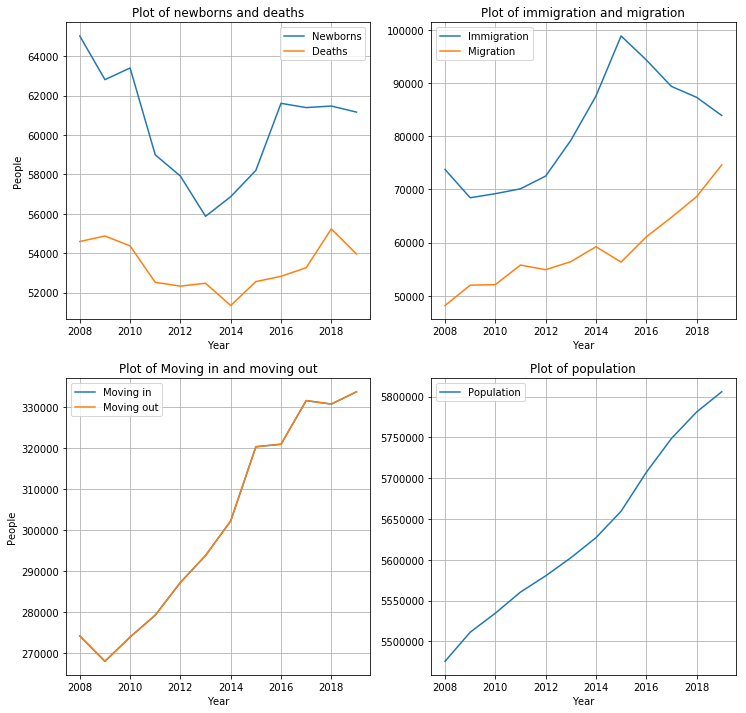

In [114]:
# Plot the values for Denmark
fig = plt.figure(figsize=(12,12)) # Defining figure size

# Defining the top left plot 
ax_left_top = fig.add_subplot(221)  
ax_left_top.plot(Total['TID'],Total['Newborns']) 
ax_left_top.plot(Total['TID'],Total['Deaths'])
ax_left_top.legend()
ax_left_top.set_title('Plot of newborns and deaths')
ax_left_top.set_xlabel('Year')
ax_left_top.set_ylabel('People')
ax_left_top.grid(True)

# Defining the bottom left plot
ax_left_bottom = fig.add_subplot(223)  
ax_left_bottom.plot(Total['TID'],Total['Moving in']) 
ax_left_bottom.plot(Total['TID'],Total['Moving out'])
ax_left_bottom.legend() 
ax_left_bottom.set_title('Plot of Moving in and moving out')
ax_left_bottom.set_xlabel('Year')
ax_left_bottom.set_ylabel('People')
ax_left_bottom.grid(True)

# Defining the top right plot
ax_right_top = fig.add_subplot(222)
ax_right_top.plot(Total['TID'],Total['Immigration'])
ax_right_top.plot(Total['TID'],Total['Migration'])
ax_right_top.set_title('Plot of immigration and migration')
ax_right_top.set_xlabel('Year')
ax_right_top.legend()
ax_right_top.grid(True)

# Defining the bottom right plot
ax_right_bottom = fig.add_subplot(224)
ax_right_bottom.plot(Total['TID'],Total['Population'])
ax_right_bottom.legend() 
ax_right_bottom.set_title('Plot of population')
ax_right_bottom.set_xlabel('Year')
ax_right_bottom.grid(True)

We now make a plot of all of Denmark, where it can be seen that moving in is equal to moving out, as this do not create population growth in Denmark, but only in municipalities. It can be seen that there is a big increase in population, which is caused by immigration into the country and more people being born compared to people dying. This has created a population growth in Denmark of around 300.000 from 2008 to 2019. It can be seen that the number of newborns following the great recession decreased, and hit a low point in 2013. After that, as the economy improved, the number of newborns increased. The graph also clearly depict the "Flytningekrise" that happend in 2015.

Further it can be seen that the number of people that move municipality has increased by almost 60.000 in the timeperiod we look at.

To get a quick overview of the general municipality in Denmark, we look at the mean of each variable in each year

In [362]:
merged6.groupby('TID').agg(['mean']).round(0)

,Immigration,Migration,Newborns,Moving out,Moving in,Deaths,Population,Population Growth
,mean,mean,mean,mean,mean,mean,mean,mean
TID,,,,,,,,
2008,753.0,492.0,664.0,2798.0,2798.0,557.0,55874.0,368.0
2009,698.0,530.0,641.0,2735.0,2735.0,560.0,56238.0,249.0
2010,706.0,532.0,647.0,2795.0,2795.0,555.0,56476.0,267.0
2011,716.0,569.0,602.0,2850.0,2850.0,536.0,56740.0,212.0
2012,740.0,560.0,591.0,2931.0,2931.0,534.0,56943.0,237.0
2013,808.0,576.0,570.0,2998.0,2998.0,535.0,57169.0,267.0
2014,894.0,604.0,580.0,3084.0,3084.0,524.0,57420.0,346.0
2015,1009.0,575.0,594.0,3269.0,3269.0,536.0,57751.0,492.0


Thus it can be seen that the average municipality in Denmark had a population of around 56.000 in 2008 and 59.000 in 2019. All variables execpt for Newborns and deaths has increased from 2008 to 2019. In the mean municipality in Denmark 40 less childen are born in 2019 compared to 2008 and 6 less people die. It can be seen that the average of moving in and moving out are equal, as this is the mean we look at.

# Conclusion

In general we see that Denmark experience an increase in number of people living in the country over the period. Though not all municipalities experience the same growth a municipality such as Læsø, which is a relativly isolated municipality, experience a negative growth in the population while a municipality such as Vejen which is still a municipality it Jutland but not as isolated experience a positive population growth in the period of 2008 - 2019.